# CNN-LSTM with Time distributed layers

In [3]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.layers import TimeDistributed
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
import pickle
from tensorflow.keras.optimizers import SGD
import numpy as np
from keras.layers import TimeDistributed, GRU, Dense, Dropout
import glob
import os
from keras_video import VideoFrameGenerator
import keras
import tensorflow as tf
from keras.models import load_model
import splitfolders as splitfolders
from sklearn.utils import class_weight

## Data Preparation

### Split folders into Training and Testing Set

In [15]:
# split the files into training and testing set

input_folder = 'Anomaly_Dataset/Anomaly_Detection/' # crime and normal should be in here
output_folder = 'Anomaly_Dataset/Anomaly_Detection/'
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8,.0,.2), group_prefix=None) # default values

Copying files: 550 files [02:33,  3.57 files/s]


### Convert videos to frames

In [ ]:
# use sub directories names as classes
classes = ['Crime','Normal']
classes.sort()

# some global params
img_size = (112, 112)
CHANNELS = 3
num_frames = 10 # number of frame extracted for each videos
batch_size = 64 # batch size
# generator produces 8 sequences of 5 frames picked from videos.

# pattern to get videos and classes of traning set
glob_pattern='D:\Anomaly_Dataset\Anomaly_Detection/train/{classname}/*.mp4'

# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1.0/255,
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
    
# Create the training set
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=num_frames,
    split=.2, 
    shuffle=True,
    batch_size=batch_size,
    target_shape=img_size,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=False)

In [ ]:
# create the validation set
valid = train.get_validation_generator()

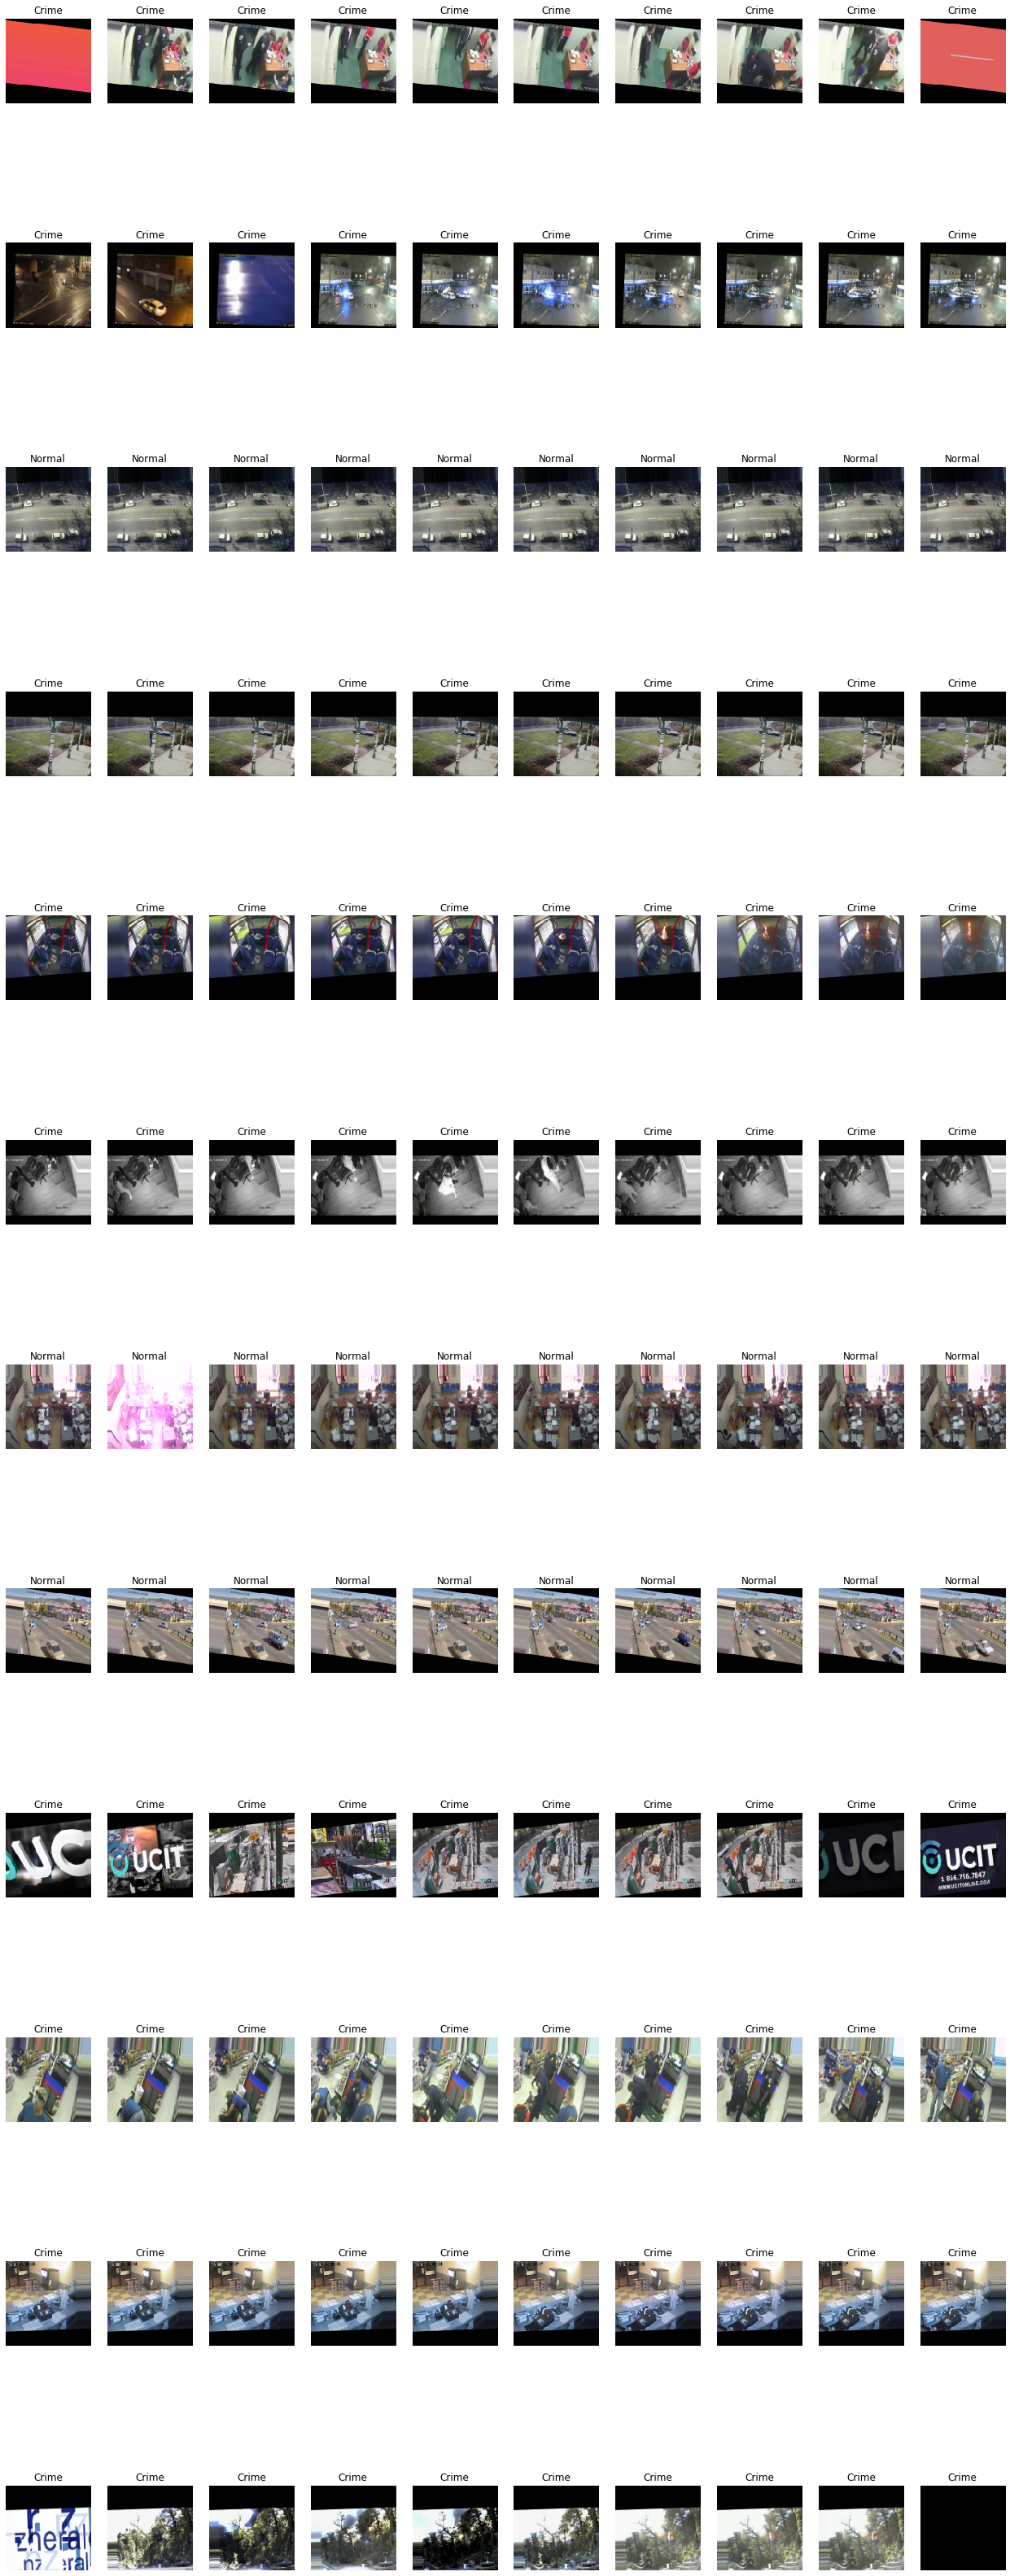

In [5]:
# show samples of the traning set

import keras_video.utils
keras_video.utils.show_sample(train,random=True)

In [5]:
# define the class weight becuase the two classes are not even

class_weight = {0:1, 1: 2.7}

## First try

In [5]:
def build_convnet(shape=(112, 112, 3)):
    
    momentum = 0.9
    
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(Flatten())
    
    return model

In [6]:
def action_model(shape=(64, 112, 112, 3),dropout_value=0.5,):
    
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    
    model.add(LSTM(64))
    
    # and finally, we make a decision network
    #model.add(Dense(1024, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_value))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_value))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax')) 
    
    return model

In [7]:
# define a callback list 

my_callbacks = [
    
    # stop if val_loss has no improvement for 4 epochs
    tf.keras.callbacks.EarlyStopping(patience=8,restore_best_weights=True,monitor='val_loss'),
    
    # save the model after each epoch, monitor the val_loss for min value, save only the best weights
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints/cnn-ltsm.{epoch:02d}-{val_loss:.2f}.h5',monitor='val_loss',
                                      save_best_only=True,mode='auto',save_freq='epoch'),
    
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]


In [11]:
INSHAPE=(num_frames,) + img_size + (CHANNELS,) # (5, 112, 112, 3)
model = action_model(INSHAPE)

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              weighted_metrics=['accuracy'])


In [12]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 100352)        4689216   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                25706752  
_________________________________________________________________
dense_4 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [13]:
hist=model.fit_generator(train,validation_data=valid,verbose=1,epochs=30,callbacks=my_callbacks,
                        shuffle=True,class_weight=class_weight)

Epoch 1/30
1/6 [====>.........................] - ETA: 0s - loss: 0.9366 - accuracy: 0.5889WARNING:tensorflow:From C:\Users\bebbi\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
6/6 [==============================] - 1147s 191s/step - loss: 1.0913 - accuracy: 0.5123 - val_loss: 0.7221 - val_accuracy: 0.2812
Epoch 2/30
6/6 [==============================] - 844s 141s/step - loss: 0.9926 - accuracy: 0.5640 - val_loss: 0.8064 - val_accuracy: 0.2812
Epoch 3/30
6/6 [==============================] - 842s 140s/step - loss: 0.9281 - accuracy: 0.6585 - val_loss: 0.6851 - val_accuracy: 0.5000
Epoch 4/30
6/6 [==============================] - 836s 139s/step - loss: 0.9000 - accuracy: 0.6277 - val_loss: 0.6138 - val_accuracy: 0.6875
Epoch 5/30
6/6 [==============================] - 807s 

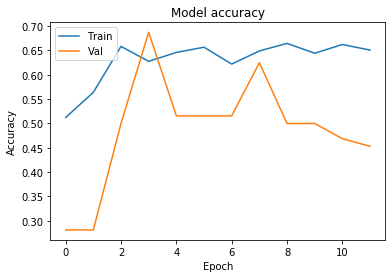

In [16]:
import matplotlib.pyplot as plt
#Visualize the models accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

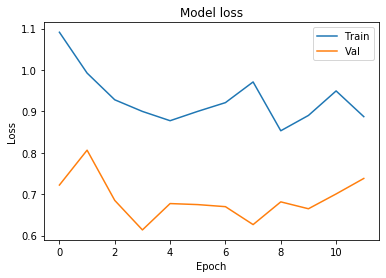

In [17]:
#Visualize the models loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Evaluate first model

In [19]:
# load the model with the best weight
cnn_ltsm_model = load_model("checkpoints/cnn-ltsm.04-0.61.h5")

In [21]:
classes = ['Crime','Normal']
classes.sort()

img_size = (112, 112)
CHANNELS = 3
num_frames = 10 # number of frame extracted for each videos
batch_size = 5

test_dir='D:\Anomaly_Dataset\Anomaly_Detection/test/{classname}/*.mp4'

test = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=test_dir,
    nb_frames=num_frames,
    shuffle=True,
    batch_size=batch_size,
    target_shape=img_size,
    nb_channel=CHANNELS,
    transformation=None,
    use_frame_cache=False)

Total data: 2 classes for 55 files for train


In [22]:
scores = cnn_ltsm_model.evaluate_generator(test)
print("Accuracy = ",scores[1])
print("Loss = ",scores[0])

Instructions for updating:
Please use Model.evaluate, which supports generators.
Accuracy =  0.6727272868156433
Loss =  0.6006941795349121


In [28]:
predict=cnn_ltsm_model.predict_generator(test,verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
11/11 [==============================] - 15s 1s/step


In [29]:
print(predict)

[[0.57893866 0.42106128]
 [0.370402   0.629598  ]
 [0.59877825 0.4012217 ]
 [0.48589256 0.51410747]
 [0.5697273  0.43027267]
 [0.50311905 0.49688086]
 [0.65126073 0.34873924]
 [0.5840877  0.41591224]
 [0.8838556  0.11614445]
 [0.53520274 0.46479723]
 [0.5763627  0.4236373 ]
 [0.50207645 0.49792352]
 [0.5439601  0.45603994]
 [0.8779663  0.12203365]
 [0.5676373  0.43236265]
 [0.38612357 0.61387646]
 [0.8023082  0.19769181]
 [0.84043217 0.15956782]
 [0.5866162  0.41338378]
 [0.8245517  0.17544827]
 [0.4797212  0.5202788 ]
 [0.5194908  0.4805092 ]
 [0.5770301  0.4229699 ]
 [0.6009287  0.39907128]
 [0.4980331  0.5019669 ]
 [0.5875162  0.41248375]
 [0.54827267 0.4517273 ]
 [0.53700686 0.46299312]
 [0.51513594 0.484864  ]
 [0.5415697  0.45843035]
 [0.595684   0.40431598]
 [0.61667657 0.38332343]
 [0.54259855 0.45740142]
 [0.62375987 0.37624016]
 [0.41936165 0.58063835]
 [0.448735   0.55126506]
 [0.5219869  0.47801316]
 [0.46819425 0.53180575]
 [0.4715552  0.5284448 ]
 [0.368648   0.63135207]


## Second Try

In [6]:
# define a callback list 

my_callbacks = [
    
    # stop if val_loss has no improvement for 10 epochs
    tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True,monitor='val_loss'),
    
    # save the model after each epoch, monitor the val_loss for min value, save only the best weights
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints/cnn-ltsm_2.{epoch:02d}-{val_loss:.2f}.h5',monitor='val_loss',
                                      save_best_only=True,mode='auto',save_freq='epoch'),
    
    #tf.keras.callbacks.TensorBoard(log_dir='./logs')
]


In [7]:
def build_convnet_2(shape=(112, 112, 3)):
    
    momentum = 0.9
    
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    # flatten...
    model.add(Flatten())
    
    return model

In [8]:
def action_model_2(shape=(64, 112, 112, 3)):
    
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet_2(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    
    model.add(LSTM(64))
    
    # and finally, we make a decision network
    #model.add(Dense(1024, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.7))  # increase dropout to prevent overfitting
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax')) 
    
    return model

In [9]:
# load the checkpoint of previous model with best weights
#model = load_model(r"models/cnn-ltsm.h5")

# get the weights from the previous model
#weights = model.get_weights()

# define new model
INSHAPE=(num_frames,) + img_size + (CHANNELS,) # (5, 112, 112, 3)
model_2 = action_model_2(INSHAPE)
model_2.summary()

# adjust the learning rate of the new model 
adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_2.compile(loss='categorical_crossentropy', 
              optimizer=adam,
              weighted_metrics=['accuracy'])

# set the weights of model_2 to previous weights
#model_2.set_weights(weights)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 50176)         1147200   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                12861696  
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In the second model: <br>
<ul> Learning rate is decreased </ul>
<ul> Dropout value increased </ul>
<ul> Number of neurons decreased </ul>

In [10]:
# batch_size = 64
hist_2=model_2.fit_generator(train,validation_data=valid,verbose=1,epochs=30,callbacks=my_callbacks,
                        shuffle=True,class_weight=class_weight)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
6/6 [==============================] - 965s 161s/step - loss: 1.0442 - accuracy: 0.5169 - val_loss: 0.8608 - val_accuracy: 0.1875
Epoch 2/30
6/6 [==============================] - 642s 107s/step - loss: 1.0385 - accuracy: 0.5339 - val_loss: 0.7879 - val_accuracy: 0.2812
Epoch 3/30
6/6 [==============================] - 613s 102s/step - loss: 1.0530 - accuracy: 0.4969 - val_loss: 0.7913 - val_accuracy: 0.2969
Epoch 4/30
6/6 [==============================] - 608s 101s/step - loss: 1.0197 - accuracy: 0.5296 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 5/30
6/6 [==============================] - 608s 101s/step - loss: 0.9831 - accuracy: 0.5726 - val_loss: 0.6434 - val_accuracy: 0.7344
Epoch 6/30
6/6 [==============================] - 598s 100s/step - loss: 1.0090 - accuracy: 0.5776 - val_loss: 0.6647 - val_accuracy: 0.5781
Epoch 7/30
6/6 [==============================] - 604s 101s/step - loss: 1.044

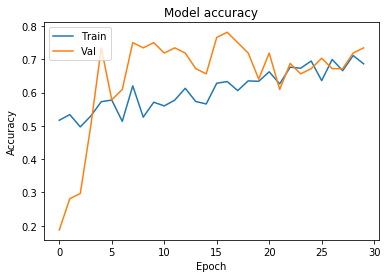

In [12]:
import matplotlib.pyplot as plt
#Visualize the models accuracy
plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

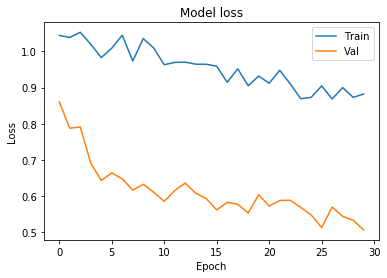

In [13]:
#Visualize the models loss
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Evaluate second model

In [ ]:
# create the test set

classes = ['Crime','Normal']
classes.sort()

img_size = (112, 112)
CHANNELS = 3
num_frames = 150 # number of frame extracted for each videos
batch_size = 5

test_dir='D:\Anomaly_Dataset\Anomaly_Detection/test/{classname}/*.mp4'

test = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=test_dir,
    nb_frames=num_frames,
    shuffle=True,
    batch_size=batch_size,
    target_shape=img_size,
    nb_channel=CHANNELS,
    transformation=None,
    use_frame_cache=False)

In [4]:
# load the best weights from model 2
best_2 = load_model('checkpoints/cnn-ltsm_2.16-0.56.h5')

In [25]:
scores = best_2.evaluate_generator(test)
print("Accuracy = ",scores[1])
print("Loss = ",scores[0])

Accuracy =  0.6909090876579285
Loss =  0.6195706725120544


## Classify Video

In [20]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer

y_train = np.load('y_train.npy')

y_test = np.load('y_test.npy')

total_labels = np.concatenate((y_train, y_test), axis=0)
labelbin = LabelBinarizer()
lb = labelbin.fit_transform(total_labels)

In [21]:
from collections import deque
import cv2

# open the video file to classify
capture = cv2.VideoCapture(r"D:\Anomaly_Dataset\Anomaly_Detection\test\Normal\Normal_Videos_051_x264.mp4")
width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))   # float
height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)) # float
Queue = deque(maxlen=200)
writer = None

In [ ]:
# loop over frames from the video file stream
while True:
    
    # read the next frame from the file
    (grabbed, frame) = capture.read()

    # if the frame was not grabbed, then we have reached the end of the stream
    if not grabbed:
        break

    # clone the output frame # ordering, resize the frame to a fixed 224x224, and then perform mean subtraction
    output = frame.copy()
    frame = cv2.resize(frame,(112,112)) /255
    #frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY )

    # make predictions on the frame and then update the predictions queue
    array = np.expand_dims(frame, axis=0)
    preds = model.predict(np.expand_dims(array, axis=0))
    Queue.append(preds)
    
    # get max prediction
    results = np.array(Queue).mean(axis=0)
    i = np.argmax(results)
    label = labelbin.classes_[i]
    
    # draw the activity on the output frame
    if label ==0:
        text = "Crime Detected"
    if label ==1:
        text = "No Crime Detected"
        
    cv2.putText(output, text, (25, 20), cv2.FONT_HERSHEY_SIMPLEX,1, (0, 255, 0), 2)

    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        writer = cv2.VideoWriter("output_cnn-ltsm.avi", fourcc, 30,(width, height))

    # write the output frame to disk
    writer.write(output)

    # show the output image
    cv2.imshow("Output", output)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# release the file pointers
writer.release()
capture.release()
cv2.destroyAllWindows()